### Problem Set #8
#### MACS 30100, Dr. Evans
#### Name: Xiang Zhang
#### snzhang@uchicago.edu

In [41]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [2]:
url = "https://raw.githubusercontent.com/UC-MACSS/persp-model_W18/master/ProblemSets/PS8/data/strongdrink.txt"
df = pd.read_csv(url)
df.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


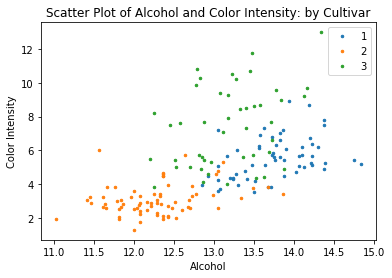

In [3]:
# I refer to the code source: https://pythonspot.com/matplotlib-scatterplot/
groups = df.groupby('cultivar')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.alco, group.color_int, marker = 'o', linestyle='', ms = 2.5, label = name)
ax.legend()
    
ax.legend()
plt.xlabel('Alcohol')
plt.ylabel('Color Intensity')
plt.title('Scatter Plot of Alcohol and Color Intensity: by Cultivar')
plt.show()

#### (b) Logit Regression

In [4]:
df['const'] = 1

xvars = ['alco', 'malic', 'tot_phen', 'color_int', 'const']
yvar = 'cultivar'

Xvals = df[xvars].values
yvals = df[yvar].values

In [5]:
k = 4
clf_mlog = KFold(n_splits = 4, shuffle = True, random_state = 22)
clf_mlog.get_n_splits(Xvals)

Log_MSE = np.zeros(k)
C = np.zeros(100)
MSE_C = np.zeros(100)

MSE_temp = np.zeros(k)

for c in range(100):
    k_ind = int(0)
    c_temp = (c + 1) / 100
    
    for train_index, test_index in clf_mlog.split(Xvals):
        X_train, X_test = Xvals[train_index], Xvals[test_index]
        y_train, y_test = yvals[train_index], yvals[test_index]
        
        # Fit Logit Regression
        LogReg = LogisticRegression(multi_class='multinomial', fit_intercept = True,
                                    solver='newton-cg', C = c_temp)
        
        LogReg.fit(X_train, y_train)
        y_pred = LogReg.predict(X_test)
        error = y_test != y_pred
        MSE_temp[k_ind] = error.mean()
        
        k_ind += 1
        
    C[c] = c_temp
    
    MSE_C[c] =  MSE_temp.mean()


In [6]:
Logitmodel_MSE = pd.DataFrame({'C':C, 'MSE':MSE_C})
Logitmodel_MSE = Logitmodel_MSE.sort_values(['MSE'])

In [7]:
Logitmodel_MSE.head(25)

,C,MSE
36,0.37,0.068182
29,0.30,0.068182
30,0.31,0.068182
31,0.32,0.068182
32,0.33,0.068182
33,0.34,0.068182
34,0.35,0.068182
35,0.36,0.068182
37,0.38,0.068182
38,0.39,0.068182


#### From the table above, we can see that the first 21 C values yield the same MSE value, thus, we can choose C value ranging from 0.28 to 0.44 (inclusive)

#### (c) Random Forest

In [8]:
def RF_model(X, y, n_estimator, md, msl):
    RF = RandomForestClassifier(n_estimators = n_estimator, 
                                min_samples_leaf = msl,
                                max_depth = md, 
                                bootstrap = True, 
                                oob_score = True, 
                                random_state=22)
    RF.fit(X, y)
    
    return (1 - RF.oob_score_)

In [29]:
Num_n_estimator = 300
Num_max_depth = 15
Num_min_samples_leaf = 100


RF_MSE_single = pd.DataFrame({'n_estimator' : np.zeros(6),
                              'max_depth' : np.zeros(6),
                              'min_samples_leaf' : np.zeros(6),
                              'MSE' : np.zeros(6)})
RF_model_MSE = RF_MSE_single[:0]

for msl in range(0, Num_min_samples_leaf, 10):
    for md in range(0, Num_max_depth):
        for n_estimator in range(0, Num_n_estimator, 50):
            position = int(n_estimator / 50)
            print(msl, md, n_estimator, position)
            RF_MSE_single['n_estimator'][position] = n_estimator + 10
            RF_MSE_single['max_depth'][position] = md + 1
            RF_MSE_single['min_samples_leaf'][position] = msl * 5 + 5
            RF_MSE_single['MSE'][position] = RF_model(Xvals, yvals, n_estimator + 1, md + 1, msl * 5 + 5)
            print(RF_MSE_single['MSE'][position])
            
        RF_model_MSE = pd.concat([RF_model_MSE, RF_MSE_single])

0 0 0 0
0.517045454545
0 0 50 1
0.153409090909
0 0 100 2
0.159090909091
0

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 0 150 3
0.136363636364
0 0 200 4
0.142045454545
0 0 250 5
0.125
0 1 0 0
0.4375
0 1 50 1
0.113636363636
0 1 100 2
0.0795454545455
0 1 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.0795454545455
0 1 200 4
0.0852272727273
0 1 250 5
0.0795454545455
0 2 0 0
0.443181818182
0 2 50 1
0.0795454545455
0 2 100 2
0.0681818181818
0 2 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.0625
0 2 200 4
0.0681818181818
0 2 250 5
0.0625
0 3 0 0
0.443181818182
0 3 50 1
0.0852272727273
0 3 100 2
0.0795454545455
0 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3 150 3
0.0852272727273
0 3 200 4
0.0795454545455
0 3 250 5
0.0738636363636
0 4 0 0
0.448863636364
0 4 50 1
0.0909090909091
0 4 100 2
0.0795454545455
0

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 4 150 3
0.0738636363636
0 4 200 4
0.0795454545455
0 4 250 5
0.0738636363636
0 5 0 0
0.448863636364
0 5 50 1
0.0909090909091
0 5 100 2
0.0795454545455
0 5

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.0738636363636
0 5 200 4
0.0795454545455
0 5 250 5
0.0738636363636
0 6 0 0
0.448863636364
0 6 50 1
0.0909090909091
0 6 100 2
0.0795454545455
0

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 6 150 3
0.0738636363636
0 6 200 4
0.0795454545455
0 6 250 5
0.0738636363636
0 7 0 0
0.448863636364
0 7 50 1
0.0909090909091
0 7 100 2
0.0795454545455
0

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 7 150 3
0.0738636363636
0 7 200 4
0.0795454545455
0 7 250 5
0.0738636363636
0 8 0 0
0.448863636364
0 8 50 1
0.0909090909091
0 8 100 2
0.0795454545455

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])



0 8 150 3
0.0738636363636
0 8 200 4
0.0795454545455
0 8 250 5
0.0738636363636
0 9 0 0
0.448863636364
0 9 50 1
0.0909090909091
0 9 100 2
0.0795454545455

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])



0 9 150 3
0.0738636363636
0 9 200 4
0.0795454545455
0 9 250 5
0.0738636363636
0 10 0 0
0.448863636364
0 10 50 1
0.0909090909091
0 10 100 2
0.0795454545455
0 10

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.0738636363636
0 10 200 4
0.0795454545455
0 10 250 5
0.0738636363636
0 11 0 0
0.448863636364
0 11 50 1
0.0909090909091
0 11 100 2
0.0795454545455
0 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


11 150 3
0.0738636363636
0 11 200 4
0.0795454545455
0 11 250 5
0.0738636363636
0 12 0 0
0.448863636364
0 12 50 1
0.0909090909091
0 12 100 2
0.0795454545455
0 12 150 3

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])



0.0738636363636
0 12 200 4
0.0795454545455
0 12 250 5
0.0738636363636
0 13 0 0
0.448863636364
0 13 50 1
0.0909090909091
0 13 100 2
0.0795454545455
0

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 13 150 3
0.0738636363636
0 13 200 4
0.0795454545455
0 13 250 5
0.0738636363636
0 14 0 0
0.448863636364
0 14 50 1
0.0909090909091
0 14 100 2
0.0795454545455
0 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


14 150 3
0.0738636363636
0 14 200 4
0.0795454545455
0 14 250 5
0.0738636363636
10 0 0 0
0.590909090909
10 0 50 1
0.261363636364
10 0 100 2
0.301136363636
10

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 0 150 3
0.301136363636
10 0 200 4
0.318181818182
10 0 250 5
0.289772727273
10 1 0 0
0.590909090909
10 1 50 1
0.261363636364
10 1 100 2
0.301136363636
10 1

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.301136363636
10 1 200 4
0.318181818182
10 1 250 5
0.289772727273
10 2 0 0
0.590909090909
10 2 50 1
0.261363636364
10 2 100 2
0.301136363636
10 2

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.301136363636
10 2 200 4
0.318181818182
10 2 250 5
0.289772727273
10 3 0 0
0.590909090909
10 3 50 1
0.261363636364
10 3 100 2
0.301136363636
10 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3 150 3
0.301136363636
10 3 200 4
0.318181818182
10 3 250 5
0.289772727273
10 4 0 0
0.590909090909
10 4 50 1
0.261363636364
10 4 100 2
0.301136363636
10 4 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.301136363636
10 4 200 4
0.318181818182
10 4 250 5
0.289772727273
10 5 0 0
0.590909090909
10 5 50 1
0.261363636364
10 5 100 2
0.301136363636
10 5 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.301136363636
10 5 200 4
0.318181818182
10 5 250 5
0.289772727273
10 6 0 0
0.590909090909
10 6 50 1
0.261363636364
10 6 100 2
0.301136363636
10 6 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.301136363636
10 6 200 4
0.318181818182
10 6 250 5
0.289772727273
10 7 0 0
0.590909090909
10 7 50 1
0.261363636364
10 7 100 2
0.301136363636
10 7

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.301136363636
10 7 200 4
0.318181818182
10 7 250 5
0.289772727273
10 8 0 0
0.590909090909
10 8 50 1
0.261363636364
10 8 100 2
0.301136363636
10 8 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.301136363636
10 8 200 4
0.318181818182
10 8 250 5
0.289772727273
10 9 0 0
0.590909090909
10 9 50 1
0.261363636364
10 9 100 2
0.301136363636
10 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


9 150 3
0.301136363636
10 9 200 4
0.318181818182
10 9 250 5
0.289772727273
10 10 0 0
0.590909090909
10 10 50 1
0.261363636364
10 10 100 2
0.301136363636
10 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10 150 3
0.301136363636
10 10 200 4
0.318181818182
10 10 250 5
0.289772727273
10 11 0 0
0.590909090909
10 11 50 1
0.261363636364
10 11 100 2
0.301136363636
10 11

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.301136363636
10 11 200 4
0.318181818182
10 11 250 5
0.289772727273
10 12 0 0
0.590909090909
10 12 50 1
0.261363636364
10 12 100 2
0.301136363636
10 12 150 3


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.301136363636
10 12 200 4
0.318181818182
10 12 250 5
0.289772727273
10 13 0 0
0.590909090909
10 13 50 1
0.261363636364
10 13 100 2
0.301136363636
10 13

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.301136363636
10 13 200 4
0.318181818182
10 13 250 5
0.289772727273
10 14 0 0
0.590909090909
10 14 50 1
0.261363636364
10 14 100 2
0.301136363636
10 14 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.301136363636
10 14 200 4
0.318181818182
10 14 250 5
0.289772727273
20 0 0 0
0.590909090909
20 0 50 1
0.596590909091
20 0 100 2
0.596590909091
20 0 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
20 0 200 4
0.596590909091
20 0 250 5
0.596590909091
20 1 0 0
0.590909090909
20 1 50 1
0.596590909091
20 1 100 2
0.596590909091
20

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 1 150 3
0.596590909091
20 1 200 4
0.596590909091
20 1 250 5
0.596590909091
20 2 0 0
0.590909090909
20 2 50 1
0.596590909091
20 2 100 2
0.596590909091
20 2

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
20 2 200 4
0.596590909091
20 2 250 5
0.596590909091
20 3 0 0
0.590909090909
20 3 50 1
0.596590909091
20 3 100 2
0.596590909091
20 3

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
20 3 200 4
0.596590909091
20 3 250 5
0.596590909091
20 4 0 0
0.590909090909
20 4 50 1
0.596590909091
20 4 100 2
0.596590909091
20 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


4 150 3
0.596590909091
20 4 200 4
0.596590909091
20 4 250 5
0.596590909091
20 5 0 0
0.590909090909
20 5 50 1
0.596590909091
20 5 100 2
0.596590909091
20 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5 150 3
0.596590909091
20 5 200 4
0.596590909091
20 5 250 5
0.596590909091
20 6 0 0
0.590909090909
20 6 50 1
0.596590909091
20 6 100 2
0.596590909091
20 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


6 150 3
0.596590909091
20 6 200 4
0.596590909091
20 6 250 5
0.596590909091
20 7 0 0
0.590909090909
20 7 50 1
0.596590909091
20 7 100 2
0.596590909091
20 7

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
20 7 200 4
0.596590909091
20 7 250 5
0.596590909091
20 8 0 0
0.590909090909
20 8 50 1
0.596590909091
20 8 100 2
0.596590909091
20 8 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
20 8 200 4
0.596590909091
20 8 250 5
0.596590909091
20 9 0 0
0.590909090909
20 9 50 1
0.596590909091
20 9 100 2
0.596590909091
20 9

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
20 9 200 4
0.596590909091
20 9 250 5
0.596590909091
20 10 0 0
0.590909090909
20 10 50 1
0.596590909091
20 10 100 2
0.596590909091
20 10 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
20 10 200 4
0.596590909091
20 10 250 5
0.596590909091
20 11 0 0
0.590909090909
20 11 50 1
0.596590909091
20 11 100 2
0.596590909091
20 11 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
20 11 200 4
0.596590909091
20 11 250 5
0.596590909091
20 12 0 0
0.590909090909
20 12 50 1
0.596590909091
20 12 100 2
0.596590909091
20 12 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.596590909091
20 12 200 4
0.596590909091
20 12 250 5
0.596590909091
20 13 0 0
0.590909090909
20 13 50 1
0.596590909091
20 13 100 2
0.596590909091
20 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


13 150 3
0.596590909091
20 13 200 4
0.596590909091
20 13 250 5
0.596590909091
20 14 0 0
0.590909090909
20 14 50 1
0.596590909091
20 14 100 2
0.596590909091
20 14 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.596590909091
20 14 200 4
0.596590909091
20 14 250 5
0.596590909091
30 0 0 0
0.590909090909
30 0 50 1
0.596590909091
30 0 100 2
0.596590909091
30 0 150 3

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])



0.596590909091
30 0 200 4
0.596590909091
30 0 250 5
0.596590909091
30 1 0 0
0.590909090909
30 1 50 1
0.596590909091
30 1 100 2
0.596590909091
30 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1 150 3
0.596590909091
30 1 200 4
0.596590909091
30 1 250 5
0.596590909091
30 2 0 0
0.590909090909
30 2 50 1
0.596590909091
30 2 100 2
0.596590909091
30 2 150 3


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.596590909091
30 2 200 4
0.596590909091
30 2 250 5
0.596590909091
30 3 0 0
0.590909090909
30 3 50 1
0.596590909091
30 3 100 2
0.596590909091
30 3

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
30 3 200 4
0.596590909091
30 3 250 5
0.596590909091
30 4 0 0
0.590909090909
30 4 50 1
0.596590909091
30 4 100 2
0.596590909091
30 4 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.596590909091
30 4 200 4
0.596590909091
30 4 250 5
0.596590909091
30 5 0 0
0.590909090909
30 5 50 1
0.596590909091
30 5 100 2
0.596590909091
30 5 150 3


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.596590909091
30 5 200 4
0.596590909091
30 5 250 5
0.596590909091
30 6 0 0
0.590909090909
30 6 50 1
0.596590909091
30 6 100 2
0.596590909091
30 6 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.596590909091
30 6 200 4
0.596590909091
30 6 250 5
0.596590909091
30 7 0 0
0.590909090909
30 7 50 1
0.596590909091
30 7 100 2
0.596590909091
30 7

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
30 7 200 4
0.596590909091
30 7 250 5
0.596590909091
30 8 0 0
0.590909090909
30 8 50 1
0.596590909091
30 8 100 2
0.596590909091
30 8 150 3

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])



0.596590909091
30 8 200 4
0.596590909091
30 8 250 5
0.596590909091
30 9 0 0
0.590909090909
30 9 50 1
0.596590909091
30 9 100 2
0.596590909091
30 9

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
30 9 200 4
0.596590909091
30 9 250 5
0.596590909091
30 10 0 0
0.590909090909
30 10 50 1
0.596590909091
30 10 100 2
0.596590909091
30 10

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
30 10 200 4
0.596590909091
30 10 250 5
0.596590909091
30 11 0 0
0.590909090909
30 11 50 1
0.596590909091
30 11 100 2
0.596590909091
30 11 150 3


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.596590909091
30 11 200 4
0.596590909091
30 11 250 5
0.596590909091
30 12 0 0
0.590909090909
30 12 50 1
0.596590909091
30 12 100 2
0.596590909091
30 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


12 150 3
0.596590909091
30 12 200 4
0.596590909091
30 12 250 5
0.596590909091
30 13 0 0
0.590909090909
30 13 50 1
0.596590909091
30 13 100 2
0.596590909091
30 13

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
30 13 200 4
0.596590909091
30 13 250 5
0.596590909091
30 14 0 0
0.590909090909
30 14 50 1
0.596590909091
30 14 100 2
0.596590909091
30 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


14 150 3
0.596590909091
30 14 200 4
0.596590909091
30 14 250 5
0.596590909091
40 0 0 0
0.590909090909
40 0 50 1
0.596590909091
40 0 100 2
0.596590909091
40 0

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
40 0 200 4
0.596590909091
40 0 250 5
0.596590909091
40 1 0 0
0.590909090909
40 1 50 1
0.596590909091
40 1 100 2
0.596590909091
40 1

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
40 1 200 4
0.596590909091
40 1 250 5
0.596590909091
40 2 0 0
0.590909090909
40 2 50 1
0.596590909091
40 2 100 2
0.596590909091
40 2

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
40 2 200 4
0.596590909091
40 2 250 5
0.596590909091
40 3 0 0
0.590909090909
40 3 50 1
0.596590909091
40 3 100 2
0.596590909091
40 3 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
40 3 200 4
0.596590909091
40 3 250 5
0.596590909091
40 4 0 0
0.590909090909
40 4 50 1
0.596590909091
40 4 100 2
0.596590909091
40 4 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.596590909091
40 4 200 4
0.596590909091
40 4 250 5
0.596590909091
40 5 0 0
0.590909090909
40 5 50 1
0.596590909091
40 5 100 2
0.596590909091
40 5 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.596590909091
40 5 200 4
0.596590909091
40 5 250 5
0.596590909091
40 6 0 0
0.590909090909
40 6 50 1
0.596590909091
40 6 100 2
0.596590909091
40 6

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
40 6 200 4
0.596590909091
40 6 250 5
0.596590909091
40 7 0 0
0.590909090909
40 7 50 1
0.596590909091
40 7 100 2
0.596590909091
40 7 150 3


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.596590909091
40 7 200 4
0.596590909091
40 7 250 5
0.596590909091
40 8 0 0
0.590909090909
40 8 50 1
0.596590909091
40 8 100 2
0.596590909091
40 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


8 150 3
0.596590909091
40 8 200 4
0.596590909091
40 8 250 5
0.596590909091
40 9 0 0
0.590909090909
40 9 50 1
0.596590909091
40 9 100 2
0.596590909091
40 9 150 3


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.596590909091
40 9 200 4
0.596590909091
40 9 250 5
0.596590909091
40 10 0 0
0.590909090909
40 10 50 1
0.596590909091
40 10 100 2
0.596590909091
40 10

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
40 10 200 4
0.596590909091
40 10 250 5
0.596590909091
40 11 0 0
0.590909090909
40 11 50 1
0.596590909091
40 11 100 2
0.596590909091
40 11 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
40 11 200 4
0.596590909091
40 11 250 5
0.596590909091
40 12 0 0
0.590909090909
40 12 50 1
0.596590909091
40 12 100 2
0.596590909091
40 12 150 3

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])



0.596590909091
40 12 200 4
0.596590909091
40 12 250 5
0.596590909091
40 13 0 0
0.590909090909
40 13 50 1
0.596590909091
40 13 100 2
0.596590909091
40 13 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
40 13 200 4
0.596590909091
40 13 250 5
0.596590909091
40 14 0 0
0.590909090909
40 14 50 1
0.596590909091
40 14 100 2
0.596590909091
40 14 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.596590909091
40 14 200 4
0.596590909091
40 14 250 5
0.596590909091
50 0 0 0
0.590909090909
50 0 50 1
0.596590909091
50 0 100 2
0.596590909091
50 0

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
50 0 200 4
0.596590909091
50 0 250 5
0.596590909091
50 1 0 0
0.590909090909
50 1 50 1
0.596590909091
50 1 100 2
0.596590909091
50

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 1 150 3
0.596590909091
50 1 200 4
0.596590909091
50 1 250 5
0.596590909091
50 2 0 0
0.590909090909
50 2 50 1
0.596590909091
50 2 100 2
0.596590909091
50 2 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.596590909091
50 2 200 4
0.596590909091
50 2 250 5
0.596590909091
50 3 0 0
0.590909090909
50 3 50 1
0.596590909091
50 3 100 2
0.596590909091
50 3

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
50 3 200 4
0.596590909091
50 3 250 5
0.596590909091
50 4 0 0
0.590909090909
50 4 50 1
0.596590909091
50 4 100 2
0.596590909091
50

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 4 150 3
0.596590909091
50 4 200 4
0.596590909091
50 4 250 5
0.596590909091
50 5 0 0
0.590909090909
50 5 50 1
0.596590909091
50 5 100 2
0.596590909091
50 5 150 3


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.596590909091
50 5 200 4
0.596590909091
50 5 250 5
0.596590909091
50 6 0 0
0.590909090909
50 6 50 1
0.596590909091
50 6 100 2
0.596590909091
50 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


6 150 3
0.596590909091
50 6 200 4
0.596590909091
50 6 250 5
0.596590909091
50 7 0 0
0.590909090909
50 7 50 1
0.596590909091
50 7 100 2
0.596590909091
50 7 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
50 7 200 4
0.596590909091
50 7 250 5
0.596590909091
50 8 0 0
0.590909090909
50 8 50 1
0.596590909091
50 8 100 2
0.596590909091
50 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


8 150 3
0.596590909091
50 8 200 4
0.596590909091
50 8 250 5
0.596590909091
50 9 0 0
0.590909090909
50 9 50 1
0.596590909091
50 9 100 2
0.596590909091
50 9 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
50 9 200 4
0.596590909091
50 9 250 5
0.596590909091
50 10 0 0
0.590909090909
50 10 50 1
0.596590909091
50 10 100 2
0.596590909091
50 10 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
50 10 200 4
0.596590909091
50 10 250 5
0.596590909091
50 11 0 0
0.590909090909
50 11 50 1
0.596590909091
50 11 100 2
0.596590909091
50 11 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.596590909091
50 11 200 4
0.596590909091
50 11 250 5
0.596590909091
50 12 0 0
0.590909090909
50 12 50 1
0.596590909091
50 12 100 2
0.596590909091
50

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 12 150 3
0.596590909091
50 12 200 4
0.596590909091
50 12 250 5
0.596590909091
50 13 0 0
0.590909090909
50 13 50 1
0.596590909091
50 13 100 2
0.596590909091
50 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


13 150 3
0.596590909091
50 13 200 4
0.596590909091
50 13 250 5
0.596590909091
50 14 0 0
0.590909090909
50 14 50 1
0.596590909091
50 14 100 2
0.596590909091
50 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


14 150 3
0.596590909091
50 14 200 4
0.596590909091
50 14 250 5
0.596590909091
60 0 0 0
0.590909090909
60 0 50 1
0.596590909091
60 0 100 2
0.596590909091
60 0 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
60 0 200 4
0.596590909091
60 0 250 5
0.596590909091
60 1 0 0
0.590909090909
60 1 50 1
0.596590909091
60 1 100 2
0.596590909091
60 1 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.596590909091
60 1 200 4
0.596590909091
60 1 250 5
0.596590909091
60 2 0 0
0.590909090909
60 2 50 1
0.596590909091
60 2 100 2
0.596590909091
60 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


2 150 3
0.596590909091
60 2 200 4
0.596590909091
60 2 250 5
0.596590909091
60 3 0 0
0.590909090909
60 3 50 1
0.596590909091
60 3 100 2
0.596590909091
60 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3 150 3
0.596590909091
60 3 200 4
0.596590909091
60 3 250 5
0.596590909091
60 4 0 0
0.590909090909
60 4 50 1
0.596590909091
60 4 100 2
0.596590909091
60 4 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
60 4 200 4
0.596590909091
60 4 250 5
0.596590909091
60 5 0 0
0.590909090909
60 5 50 1
0.596590909091
60 5 100 2
0.596590909091
60 5

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
60 5 200 4
0.596590909091
60 5 250 5
0.596590909091
60 6 0 0
0.590909090909
60 6 50 1
0.596590909091
60 6 100 2
0.596590909091
60 6 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
60 6 200 4
0.596590909091
60 6 250 5
0.596590909091
60 7 0 0
0.590909090909
60 7 50 1
0.596590909091
60 7 100 2
0.596590909091
60 7 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.596590909091
60 7 200 4
0.596590909091
60 7 250 5
0.596590909091
60 8 0 0
0.590909090909
60 8 50 1
0.596590909091
60 8 100 2
0.596590909091
60 8

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
60 8 200 4
0.596590909091
60 8 250 5
0.596590909091
60 9 0 0
0.590909090909
60 9 50 1
0.596590909091
60 9 100 2
0.596590909091
60

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 9 150 3
0.596590909091
60 9 200 4
0.596590909091
60 9 250 5
0.596590909091
60 10 0 0
0.590909090909
60 10 50 1
0.596590909091
60 10 100 2
0.596590909091
60 10

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
60 10 200 4
0.596590909091
60 10 250 5
0.596590909091
60 11 0 0
0.590909090909
60 11 50 1
0.596590909091
60 11 100 2
0.596590909091


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


60 11 150 3
0.596590909091
60 11 200 4
0.596590909091
60 11 250 5
0.596590909091
60 12 0 0
0.590909090909
60 12 50 1
0.596590909091
60 12 100 2
0.596590909091
60 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


12 150 3
0.596590909091
60 12 200 4
0.596590909091
60 12 250 5
0.596590909091
60 13 0 0
0.590909090909
60 13 50 1
0.596590909091
60 13 100 2
0.596590909091
60 13

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
60 13 200 4
0.596590909091
60 13 250 5
0.596590909091
60 14 0 0
0.590909090909
60 14 50 1
0.596590909091
60 14 100 2
0.596590909091
60 14

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
60 14 200 4
0.596590909091
60 14 250 5
0.596590909091
70 0 0 0
0.590909090909
70 0 50 1
0.596590909091
70 0 100 2
0.596590909091
70 0

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
70 0 200 4
0.596590909091
70 0 250 5
0.596590909091
70 1 0 0
0.590909090909
70 1 50 1
0.596590909091
70 1 100 2
0.596590909091
70 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


1 150 3
0.596590909091
70 1 200 4
0.596590909091
70 1 250 5
0.596590909091
70 2 0 0
0.590909090909
70 2 50 1
0.596590909091
70 2 100 2
0.596590909091
70 2 150 3


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.596590909091
70 2 200 4
0.596590909091
70 2 250 5
0.596590909091
70 3 0 0
0.590909090909
70 3 50 1
0.596590909091
70 3 100 2
0.596590909091
70 3

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
70 3 200 4
0.596590909091
70 3 250 5
0.596590909091
70 4 0 0
0.590909090909
70 4 50 1
0.596590909091
70 4 100 2
0.596590909091
70 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


4 150 3
0.596590909091
70 4 200 4
0.596590909091
70 4 250 5
0.596590909091
70 5 0 0
0.590909090909
70 5 50 1
0.596590909091
70 5 100 2
0.596590909091
70 5

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
70 5 200 4
0.596590909091
70 5 250 5
0.596590909091
70 6 0 0
0.590909090909
70 6 50 1
0.596590909091
70 6 100 2
0.596590909091
70 6

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
70 6 200 4
0.596590909091
70 6 250 5
0.596590909091
70 7 0 0
0.590909090909
70 7 50 1
0.596590909091
70 7 100 2
0.596590909091
70 7 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
70 7 200 4
0.596590909091
70 7 250 5
0.596590909091
70 8 0 0
0.590909090909
70 8 50 1
0.596590909091
70 8 100 2
0.596590909091
70 8 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
70 8 200 4
0.596590909091
70 8 250 5
0.596590909091
70 9 0 0
0.590909090909
70 9 50 1
0.596590909091
70 9 100 2
0.596590909091
70 9 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
70 9 200 4
0.596590909091
70 9 250 5
0.596590909091
70 10 0 0
0.590909090909
70 10 50 1
0.596590909091
70 10 100 2
0.596590909091
70 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


10 150 3
0.596590909091
70 10 200 4
0.596590909091
70 10 250 5
0.596590909091
70 11 0 0
0.590909090909
70 11 50 1
0.596590909091
70 11 100 2
0.596590909091
70 11 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.596590909091
70 11 200 4
0.596590909091
70 11 250 5
0.596590909091
70 12 0 0
0.590909090909
70 12 50 1
0.596590909091
70 12 100 2
0.596590909091
70

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 12 150 3
0.596590909091
70 12 200 4
0.596590909091
70 12 250 5
0.596590909091
70 13 0 0
0.590909090909
70 13 50 1
0.596590909091
70 13 100 2
0.596590909091
70 13 150 3

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])



0.596590909091
70 13 200 4
0.596590909091
70 13 250 5
0.596590909091
70 14 0 0
0.590909090909
70 14 50 1
0.596590909091
70 14 100 2
0.596590909091
70 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


14 150 3
0.596590909091
70 14 200 4
0.596590909091
70 14 250 5
0.596590909091
80 0 0 0
0.590909090909
80 0 50 1
0.596590909091
80 0 100 2
0.596590909091
80 0

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
80 0 200 4
0.596590909091
80 0 250 5
0.596590909091
80 1 0 0
0.590909090909
80 1 50 1
0.596590909091
80 1 100 2
0.596590909091
80 1 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.596590909091
80 1 200 4
0.596590909091
80 1 250 5
0.596590909091
80 2 0 0
0.590909090909
80 2 50 1
0.596590909091
80 2 100 2
0.596590909091
80 2

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
80 2 200 4
0.596590909091
80 2 250 5
0.596590909091
80 3 0 0
0.590909090909
80 3 50 1
0.596590909091
80 3 100 2
0.596590909091
80 3

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
80 3 200 4
0.596590909091
80 3 250 5
0.596590909091
80 4 0 0
0.590909090909
80 4 50 1
0.596590909091
80 4 100 2
0.596590909091
80 4 150 3


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.596590909091
80 4 200 4
0.596590909091
80 4 250 5
0.596590909091
80 5 0 0
0.590909090909
80 5 50 1
0.596590909091
80 5 100 2
0.596590909091
80 5 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.596590909091
80 5 200 4
0.596590909091
80 5 250 5
0.596590909091
80 6 0 0
0.590909090909
80 6 50 1
0.596590909091
80 6 100 2
0.596590909091
80 6 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.596590909091
80 6 200 4
0.596590909091
80 6 250 5
0.596590909091
80 7 0 0
0.590909090909
80 7 50 1
0.596590909091
80 7 100 2
0.596590909091
80 7

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
80 7 200 4
0.596590909091
80 7 250 5
0.596590909091
80 8 0 0
0.590909090909
80 8 50 1
0.596590909091
80 8 100 2
0.596590909091
80

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 8 150 3
0.596590909091
80 8 200 4
0.596590909091
80 8 250 5
0.596590909091
80 9 0 0
0.590909090909
80 9 50 1
0.596590909091
80 9 100 2
0.596590909091
80 9 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.596590909091
80 9 200 4
0.596590909091
80 9 250 5
0.596590909091
80 10 0 0
0.590909090909
80 10 50 1
0.596590909091
80 10 100 2
0.596590909091
80 10 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
80 10 200 4
0.596590909091
80 10 250 5
0.596590909091
80 11 0 0
0.590909090909
80 11 50 1
0.596590909091
80 11 100 2
0.596590909091
80 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


11 150 3
0.596590909091
80 11 200 4
0.596590909091
80 11 250 5
0.596590909091
80 12 0 0
0.590909090909
80 12 50 1
0.596590909091
80 12 100 2
0.596590909091
80 12 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
80 12 200 4
0.596590909091
80 12 250 5
0.596590909091
80 13 0 0
0.590909090909
80 13 50 1
0.596590909091
80 13 100 2
0.596590909091
80 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


13 150 3
0.596590909091
80 13 200 4
0.596590909091
80 13 250 5
0.596590909091
80 14 0 0
0.590909090909
80 14 50 1
0.596590909091
80 14 100 2
0.596590909091
80 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


14 150 3
0.596590909091
80 14 200 4
0.596590909091
80 14 250 5
0.596590909091
90 0 0 0
0.590909090909
90 0 50 1
0.596590909091
90 0 100 2
0.596590909091
90 0 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.596590909091
90 0 200 4
0.596590909091
90 0 250 5
0.596590909091
90 1 0 0
0.590909090909
90 1 50 1
0.596590909091
90 1 100 2
0.596590909091
90 1

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
90 1 200 4
0.596590909091
90 1 250 5
0.596590909091
90 2 0 0
0.590909090909
90 2 50 1
0.596590909091
90 2 100 2
0.596590909091
90 2

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
90 2 200 4
0.596590909091
90 2 250 5
0.596590909091
90 3 0 0
0.590909090909
90 3 50 1
0.596590909091
90 3 100 2
0.596590909091
90 3 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.596590909091
90 3 200 4
0.596590909091
90 3 250 5
0.596590909091
90 4 0 0
0.590909090909
90 4 50 1
0.596590909091
90 4 100 2
0.596590909091
90 4

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
90 4 200 4
0.596590909091
90 4 250 5
0.596590909091
90 5 0 0
0.590909090909
90 5 50 1
0.596590909091
90 5 100 2
0.596590909091
90 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


5 150 3
0.596590909091
90 5 200 4
0.596590909091
90 5 250 5
0.596590909091
90 6 0 0
0.590909090909
90 6 50 1
0.596590909091
90 6 100 2
0.596590909091
90 6 150 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


3
0.596590909091
90 6 200 4
0.596590909091
90 6 250 5
0.596590909091
90 7 0 0
0.590909090909
90 7 50 1
0.596590909091
90 7 100 2
0.596590909091
90 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


7 150 3
0.596590909091
90 7 200 4
0.596590909091
90 7 250 5
0.596590909091
90 8 0 0
0.590909090909
90 8 50 1
0.596590909091
90 8 100 2
0.596590909091
90 8

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
90 8 200 4
0.596590909091
90 8 250 5
0.596590909091
90 9 0 0
0.590909090909
90 9 50 1
0.596590909091
90 9 100 2
0.596590909091
90 9 150 3


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


0.596590909091
90 9 200 4
0.596590909091
90 9 250 5
0.596590909091
90 10 0 0
0.590909090909
90 10 50 1
0.596590909091
90 10 100 2
0.596590909091
90 10 150

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 3
0.596590909091
90 10 200 4
0.596590909091
90 10 250 5
0.596590909091
90 11 0 0
0.590909090909
90 11 50 1
0.596590909091
90 11 100 2
0.596590909091
90 11

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 150 3
0.596590909091
90 11 200 4
0.596590909091
90 11 250 5
0.596590909091
90 12 0 0
0.590909090909
90 12 50 1
0.596590909091
90 12 100 2
0.596590909091


C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


90 12 150 3
0.596590909091
90 12 200 4
0.596590909091
90 12 250 5
0.596590909091
90 13 0 0
0.590909090909
90 13 50 1
0.596590909091
90 13 100 2
0.596590909091
90

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


 13 150 3
0.596590909091
90 13 200 4
0.596590909091
90 13 250 5
0.596590909091
90 14 0 0
0.590909090909
90 14 50 1
0.596590909091
90 14 100 2
0.596590909091
90 14 

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


150 3
0.596590909091
90 14 200 4
0.596590909091
90 14 250 5
0.596590909091


In [31]:
RF_model_MSE = RF_model_MSE.sort_values(['MSE'])

RF_model_MSE.head(10)

,MSE,max_depth,min_samples_leaf,n_estimator
5,0.062500,3.0,5.0,260.0
3,0.062500,3.0,5.0,160.0
2,0.068182,3.0,5.0,110.0
4,0.068182,3.0,5.0,210.0
5,0.073864,13.0,5.0,260.0
5,0.073864,11.0,5.0,260.0
3,0.073864,13.0,5.0,160.0
5,0.073864,12.0,5.0,260.0
5,0.073864,14.0,5.0,260.0
3,0.073864,12.0,5.0,160.0


#### From the table above, we can see that the random forest with ma depth = 3, and n_estimator = 160 or 260, min_samples_leaf = 5 yield the smallest MSE. However, there's one thing to keeo in mind, that is, in the loop, I set the step of n_estimator as 50, and the step for min_samples_leaf as 10, thus, I may have skipped some even better combinition that yield smaller MSE. However, if I fit the model with gap 1 (or less), it will be very computational inefficient.

#### (d) Support Vector Machine

In [92]:
k = 4
clf_svm = KFold(n_splits=4, shuffle = True, random_state=22)
clf_svm.get_n_splits(Xvals)
MSE = np.zeros(k)

MSE_C = pd.DataFrame({"C" : np.zeros(100),
                      "Gamma" : np.zeros(100),
                      "MSE" : np.zeros(100)})
MSE_SVM = MSE_C[:0]

for gm in range(100):
    for c in range(100):
        k_ind = int(0)
        g_temp = gm / 20 + 0.05
        c_temp = c / 20 + 0.05
        
        for train_index, test_index in clf_svm.split(Xvals):
            X_train, X_test = Xvals[train_index], Xvals[test_index]
            y_train, y_test = yvals[train_index], yvals[test_index]
            
            svc = svm.SVC(kernel='rbf', gamma = g_temp, C = c_temp)
            svc.fit(X_train, y_train)
            y_pred = svc.predict(X_test)
            error = y_test != y_pred
            MSE[k_ind] = error.mean()
            k_ind += 1
            
        MSE_C['C'][c] = c_temp
        MSE_C['Gamma'][c] = g_temp
        MSE_C['MSE'][c] =  MSE.mean()
        
    MSE_SVM = pd.concat([MSE_SVM, MSE_C])

In [99]:
MSE_SVM = MSE_SVM.sort_values(['MSE'])

MSE_SVM.head(10)

,C,Gamma,MSE
19,1.00,1.70,0.045455
18,0.95,1.65,0.045455
18,0.95,1.70,0.045455
91,4.60,0.10,0.051136
19,1.00,2.30,0.051136
20,1.05,2.30,0.051136
89,4.50,0.10,0.051136
23,1.20,1.65,0.051136
22,1.15,1.75,0.051136
23,1.20,1.75,0.051136


#### When cost = 1, gamma = 1.7, or when cost = 0.95, gamma = 1.65, or cost = 0.95, gamma = 1.7, the SVM model have the lowest MSE of 0.045455.

#### (e) Neural Network

In [39]:
k = 4
clf_mlp = KFold(n_splits=4, shuffle = True, random_state = 22)
clf_mlp.get_n_splits(Xvals)
MSE = np.zeros(k)

activation = np.array(['identity', 'logistic', 'tanh', 'relu'])
MSE_mlp_single = pd.DataFrame({"activation": np.zeros(20),
                               "hide_layer": np.zeros(20),
                               "alpha": np.zeros(20),
                               "MSE": np.zeros(20)})

MLP_model_MSE = MSE_mlp_single

for ac in range(0, 4):
    for h in range(8):
        for al in range(20):
            k_ind = int(0)
            
            for train_index, test_index in clf_mlp.split(Xvals):
                X_train, X_test = Xvals[train_index], Xvals[test_index]
                y_train, y_test = yvals[train_index], yvals[test_index]
                mlp = MLPClassifier(activation = activation[ac], 
                                    solver = 'lbfgs',
                                    alpha = (al/20 + 0.05), # Set the step as 0.05
                                    random_state = 25,
                                    hidden_layer_sizes = ((50 * (h + 1)),))
                
                mlp.fit(X_train, y_train)
                y_pred = mlp.predict(X_test)
                error = y_test != y_pred
                MSE[k_ind] = error.mean()
                k_ind = k_ind + 1
                
            MSE_mlp_single['activation'][al] = activation[ac]
            MSE_mlp_single['hide_layer'][al] = 50 * (h + 1)
            MSE_mlp_single['alpha'][al] = al / 20 + 0.05
            MSE_mlp_single['MSE'][al] =  MSE.mean()
            
        MLP_model_MSE = pd.concat([MLP_model_MSE, MSE_mlp_single])

C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Xiang Zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a 

In [40]:
MLP_model_MSE = MLP_model_MSE.sort_values(['MSE'])

MLP_model_MSE.head(10)

,MSE,activation,alpha,hide_layer
8,0.039773,relu,0.45,200.0
12,0.039773,relu,0.65,200.0
11,0.039773,relu,0.60,200.0
3,0.039773,relu,0.20,200.0
2,0.045455,tanh,0.15,150.0
15,0.045455,relu,0.80,300.0
6,0.045455,relu,0.35,350.0
9,0.045455,relu,0.50,350.0
15,0.045455,relu,0.80,350.0
6,0.045455,relu,0.35,200.0


From the above results, we can see that:
- Logit regression model has the smallest MSE of 0.068182
- Random Forest model has the smallest MSE of 0.062500	
- SVM has the smallest MSE of 0.045455
- MLP has the smallest MSE of 0.039773

Thus, MLP neural network model is the best predictor since it has the smallest MSE. At the same time, SVM slao has quite good performance since it only yield a little larger MSE.